In [1]:
from utils.dataloader import DataPartitions, DataGenerator
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
# sequences: array(
#   (x:Array, y:Dictionary)
# )
#
partitions = DataPartitions(
    past_frames=6,
    future_frames=1,
    root="../datasets/arda/04_21_full/",
    partial=0.6
)

In [3]:
dataset = DataGenerator(
    root="../datasets/arda/04_21_full/", 
    dataset_partitions=partitions.get_partitions(),
    past_frames=partitions.past_frames, 
    future_frames=partitions.future_frames,
    input_dim=(partitions.past_frames, 256, 256, 3),
    output_dim=(partitions.future_frames, 256, 256, 1),
    batch_size=4,
    n_channels=1,
    buffer_size=1e3,
    buffer_memory=100,
    downsampling=False,
)

In [4]:
X = dataset.get_X()
Y = dataset.get_Y()

X[X > 10e5] = 0 
Y[Y > 10e5] = 0

100%|██████████| 126/126 [01:37<00:00,  1.29it/s]


0.750043841069504


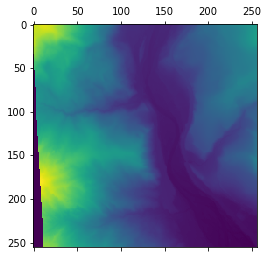

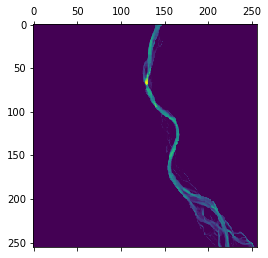

In [5]:
print(dataset.buffer_hit_ratio)

i = 3
j = 5

plt.matshow(X[j, i, 0, :, :, 2])

plt.matshow(X[j, i, 0, :, :, 0])
#plt.matshow(X[j, i, 2, :, :, 0])
#plt.matshow(X[j, i, 4, :, :, 0])
#plt.matshow(Y[j, i, 0, :, :, 0])

In [6]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

X, Y = unison_shuffled_copies(X, Y)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [8]:
print("DEP min: {}\nVEL min: {}\nBTM min: {}".format(
    np.min(X_train[:, :, :, :, :, 0]),
    np.min(X_train[:, :, :, :, :, 1]),
    np.min(X_train[:, :, :, :, :, 2])
))

print("DEP max: {}\nVEL max: {}\nBTM max: {}".format(
    np.max(X_train[:, :, :, :, :, 0]),
    np.max(X_train[:, :, :, :, :, 1]),
    np.max(X_train[:, :, :, :, :, 2])
))

DEP min: 0.0
VEL min: 0.0
BTM min: 0.0
DEP max: 4.06716
VEL max: 6.747520127609847
BTM max: 166.27399999999997


### Model

In [9]:
import numpy as np

import torch as th
import torch.nn as nn
import torch.nn.functional as F
from functools import partial

In [10]:
if th.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  
device = th.device(dev) 

In [11]:
class ResNetBlock(nn.Module):
        
    def __init__(self, in_filters, filters, stride, kernel_size, padding):
        super(ResNetBlock, self).__init__()
        
        self.activation = nn.ReLU()
        self.c1 = nn.Conv3d(in_filters, filters, kernel_size, stride, padding=padding)
        self.c2 = nn.Conv3d(filters, filters, kernel_size, padding=padding)
        self.c3 = nn.Conv3d(in_filters, filters, (1, 1, 1), stride)
        
        #self.bn = nn.BatchNorm3d(num_features=filters)

    def forward(self, x,):
        
        residual = x
        
        y = self.c1(x)

        #y = self.bn(y)
        y = self.activation(y)
        y = self.c2(y)
        #y = self.bn(y)

        # reshape
        if residual.shape != y.shape:
            residual = self.c3(residual)
            #residual = self.bn(residual)
            
        return self.activation(residual + y)


In [12]:
class Autoencoder(nn.Module):
    
    def __init__(self, channels):
        super(Autoencoder, self).__init__()

        kernel_size = 3
        padding = 1

        self.layers = nn.ModuleList([
            nn.Conv3d(channels, 8, kernel_size=kernel_size, stride=1, padding=padding),
            nn.AvgPool3d((1,2,2)),
            
            ResNetBlock(in_filters = 8, filters = 8, stride = 2, kernel_size=kernel_size, padding=padding),

            nn.Conv3d(8, 16, (1,1,1)),
            ResNetBlock(in_filters = 16, filters = 16, stride = 2, kernel_size=kernel_size, padding=padding),

            nn.Conv3d(16, 32, (1,1,1)),
            ResNetBlock(in_filters = 32, filters = 32, stride = (2,1,1), kernel_size=kernel_size, padding=padding),

            nn.Conv3d(32, 64, (1,1,1)),
            ResNetBlock(in_filters = 64, filters = 64, stride = 1, kernel_size=kernel_size, padding=padding),

            # ----------------------

            nn.ConvTranspose3d(64, 32, (1,2,2), stride=(1,2,2)),
            #nn.BatchNorm3d(num_features=32),

            nn.ConvTranspose3d(32, 16, (1,2,2), stride=(1,2,2)),
            #nn.BatchNorm3d(num_features=16),

            nn.ConvTranspose3d(16, 8, (1,2,2), stride=(1,2,2)),
            #nn.BatchNorm3d(num_features=8),

            nn.ConvTranspose3d(8, 8, (1,1,1), stride=(1,1,1)),
            #nn.BatchNorm3d(num_features=8),
            
            nn.ConvTranspose3d(8, 1, (1,1,1), stride=(1,1,1)),
        ])
    
    def forward(self, x, summary = False):
        
        if summary:
            print("==== Model Summary ====")
            print("{:<15s}{:>4s}".format("Block", "Output shape"))

        for i, l in enumerate(self.layers):
            x = l(x)
            
            if summary:
                print("{:<20s}{:>4s}".format(
                    str(l).split("(")[0],
                    str(x.shape).split("[")[1].split("]")[0]
                ))
        
        return x

In [13]:
def xavier_weights(m):
    if isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose3d):
        th.nn.init.xavier_uniform(m.weight.data)

def sqrt_weights(m):
    # https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch
    if isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose3d):
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

In [14]:
net = Autoencoder(channels=3).to(device)
net(th.Tensor(np.random.random((16, 3, 6, 128, 128))).to(device), True).shape

==== Model Summary ====
Block          Output shape
Conv3d              16, 8, 6, 128, 128
AvgPool3d           16, 8, 6, 64, 64
ResNetBlock         16, 8, 3, 32, 32
Conv3d              16, 16, 3, 32, 32
ResNetBlock         16, 16, 2, 16, 16
Conv3d              16, 32, 2, 16, 16
ResNetBlock         16, 32, 1, 16, 16
Conv3d              16, 64, 1, 16, 16
ResNetBlock         16, 64, 1, 16, 16
ConvTranspose3d     16, 32, 1, 32, 32
ConvTranspose3d     16, 16, 1, 64, 64
ConvTranspose3d     16, 8, 1, 128, 128
ConvTranspose3d     16, 8, 1, 128, 128
ConvTranspose3d     16, 1, 1, 128, 128


torch.Size([16, 1, 1, 128, 128])

In [15]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [16]:
X_train = th.Tensor(X_train).to(device)
y_train = th.Tensor(y_train).to(device)

In [17]:
X_train = X_train.permute(0, 1, 5, 2, 3, 4)
y_train = y_train.permute(0, 1, 5, 2, 3, 4)

In [18]:
X_test = th.Tensor(X_test).to(device)
y_test = th.Tensor(y_test).to(device)

In [19]:
X_test = X_test.permute(0, 1, 5, 2, 3, 4)
y_test = y_test.permute(0, 1, 5, 2, 3, 4)

In [20]:
def relative_error(y, y_true):
    return (th.norm(y - y_true, float('inf')) / th.norm(y_true, float('inf')))

In [21]:
losses = []
errors = []
test_errors = []

[0,     9] train_err: 1.002 	  test_err: 1.000 	 avg_loss: 0.072


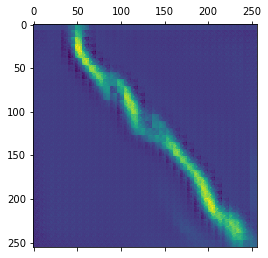

[1,    13] train_err: 1.004 	  test_err: 1.002 	 avg_loss: 0.052
[2,     5] train_err: 1.197 	  test_err: 1.001 	 avg_loss: 0.041
[3,     9] train_err: 1.021 	  test_err: 1.000 	 avg_loss: 0.035


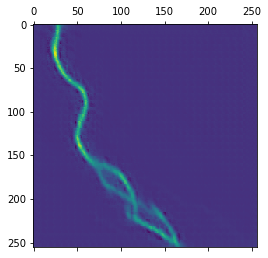

[4,    18] train_err: 0.991 	  test_err: 1.000 	 avg_loss: 0.030
[5,     2] train_err: 0.997 	  test_err: 1.255 	 avg_loss: 0.027
[6,    12] train_err: 1.001 	  test_err: 0.919 	 avg_loss: 0.025


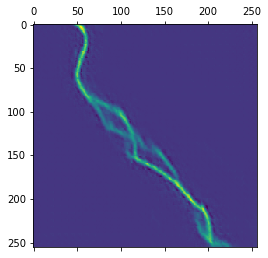

[7,    16] train_err: 1.000 	  test_err: 0.999 	 avg_loss: 0.023
[8,    20] train_err: 1.000 	  test_err: 1.001 	 avg_loss: 0.021
[9,     2] train_err: 0.999 	  test_err: 1.237 	 avg_loss: 0.020


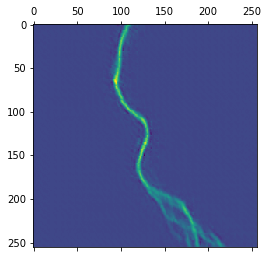

[10,    10] train_err: 1.407 	  test_err: 0.998 	 avg_loss: 0.018
[11,     4] train_err: 1.002 	  test_err: 1.189 	 avg_loss: 0.017
[12,     9] train_err: 1.239 	  test_err: 1.000 	 avg_loss: 0.017


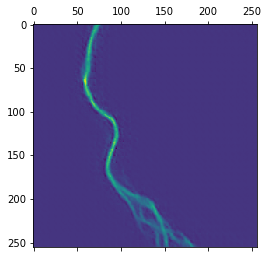

[13,    11] train_err: 1.501 	  test_err: 1.001 	 avg_loss: 0.016
[14,     2] train_err: 1.001 	  test_err: 1.229 	 avg_loss: 0.015
[15,    22] train_err: 1.671 	  test_err: 1.001 	 avg_loss: 0.015


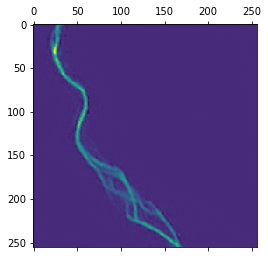

[16,     1] train_err: 0.843 	  test_err: 1.100 	 avg_loss: 0.015
[17,     7] train_err: 1.187 	  test_err: 0.999 	 avg_loss: 0.015
[18,     5] train_err: 1.484 	  test_err: 1.001 	 avg_loss: 0.015


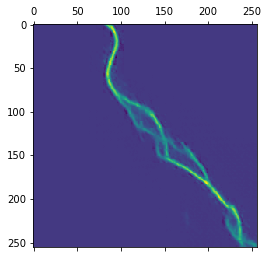

[19,    13] train_err: 1.072 	  test_err: 1.001 	 avg_loss: 0.014
[20,    16] train_err: 1.000 	  test_err: 1.001 	 avg_loss: 0.014
[21,    18] train_err: 0.995 	  test_err: 0.999 	 avg_loss: 0.014


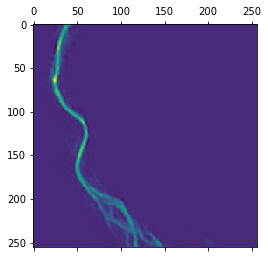

[22,    21] train_err: 1.000 	  test_err: 1.200 	 avg_loss: 0.013
[23,    23] train_err: 1.000 	  test_err: 1.000 	 avg_loss: 0.013
[24,     2] train_err: 1.000 	  test_err: 1.301 	 avg_loss: 0.013


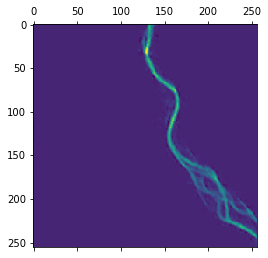

[25,    24] train_err: 0.594 	  test_err: 0.461 	 avg_loss: 0.012
[26,    15] train_err: 1.023 	  test_err: 0.999 	 avg_loss: 0.012
[27,     2] train_err: 1.000 	  test_err: 1.284 	 avg_loss: 0.012


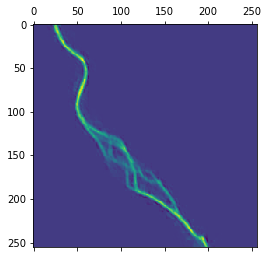

[28,     5] train_err: 1.484 	  test_err: 1.000 	 avg_loss: 0.012
[29,     9] train_err: 1.504 	  test_err: 1.000 	 avg_loss: 0.012
[30,     3] train_err: 0.515 	  test_err: 0.381 	 avg_loss: 0.011


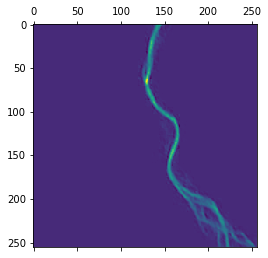

[31,    22] train_err: 1.824 	  test_err: 1.000 	 avg_loss: 0.011
[32,    13] train_err: 1.149 	  test_err: 1.000 	 avg_loss: 0.011
[33,    12] train_err: 1.001 	  test_err: 0.962 	 avg_loss: 0.011


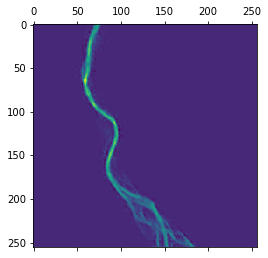

[34,    23] train_err: 1.000 	  test_err: 1.000 	 avg_loss: 0.011
[35,    16] train_err: 1.000 	  test_err: 1.000 	 avg_loss: 0.010
[36,     5] train_err: 1.494 	  test_err: 1.000 	 avg_loss: 0.010


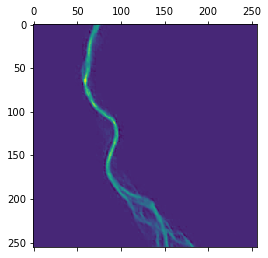

[37,    16] train_err: 1.000 	  test_err: 1.000 	 avg_loss: 0.010
[38,    11] train_err: 1.609 	  test_err: 1.000 	 avg_loss: 0.010
[39,    24] train_err: 0.536 	  test_err: 0.460 	 avg_loss: 0.010


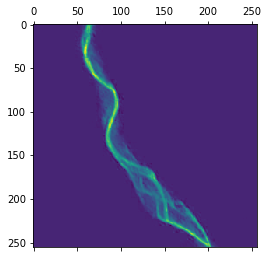

[40,    23] train_err: 1.000 	  test_err: 1.000 	 avg_loss: 0.010
[41,    23] train_err: 0.999 	  test_err: 0.999 	 avg_loss: 0.009
[42,    25] train_err: 1.000 	  test_err: 1.185 	 avg_loss: 0.009


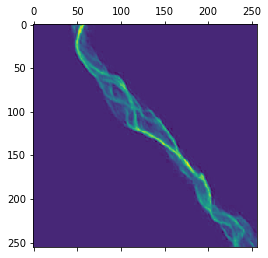

[43,     8] train_err: 1.210 	  test_err: 0.999 	 avg_loss: 0.009
[44,    17] train_err: 1.157 	  test_err: 1.000 	 avg_loss: 0.009
[45,    17] train_err: 1.160 	  test_err: 1.000 	 avg_loss: 0.009


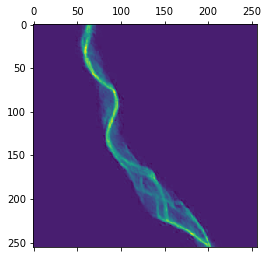

[46,    20] train_err: 1.000 	  test_err: 1.000 	 avg_loss: 0.009
[47,    21] train_err: 1.000 	  test_err: 1.082 	 avg_loss: 0.009
[48,    14] train_err: 1.000 	  test_err: 1.487 	 avg_loss: 0.009


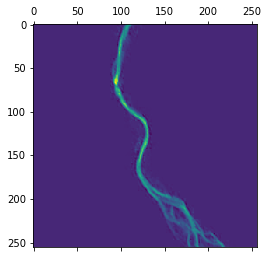

[49,     8] train_err: 1.280 	  test_err: 1.000 	 avg_loss: 0.009
[50,    23] train_err: 0.999 	  test_err: 0.999 	 avg_loss: 0.008
[51,    15] train_err: 1.059 	  test_err: 0.999 	 avg_loss: 0.008


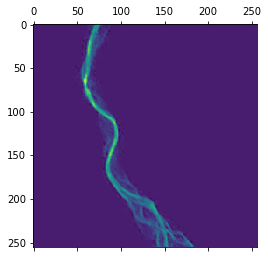

[52,    15] train_err: 1.029 	  test_err: 0.999 	 avg_loss: 0.008
[53,    12] train_err: 0.999 	  test_err: 1.000 	 avg_loss: 0.008
[54,     6] train_err: 1.000 	  test_err: 1.147 	 avg_loss: 0.008


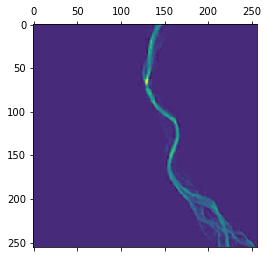

[55,    25] train_err: 1.000 	  test_err: 1.336 	 avg_loss: 0.008
[56,     7] train_err: 1.154 	  test_err: 1.000 	 avg_loss: 0.008
[57,    22] train_err: 1.945 	  test_err: 1.000 	 avg_loss: 0.008


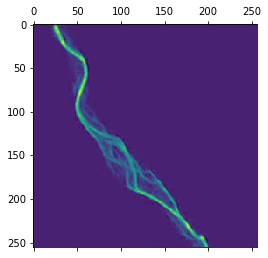

[58,    25] train_err: 1.000 	  test_err: 1.359 	 avg_loss: 0.008
[59,    24] train_err: 0.464 	  test_err: 0.458 	 avg_loss: 0.008
[60,     9] train_err: 1.418 	  test_err: 1.000 	 avg_loss: 0.008


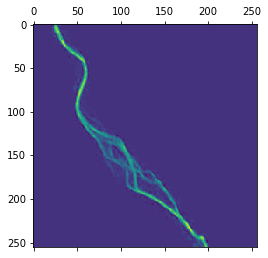

[61,    21] train_err: 1.000 	  test_err: 1.090 	 avg_loss: 0.007
[62,    23] train_err: 1.000 	  test_err: 1.000 	 avg_loss: 0.007
[63,    22] train_err: 1.945 	  test_err: 1.000 	 avg_loss: 0.007


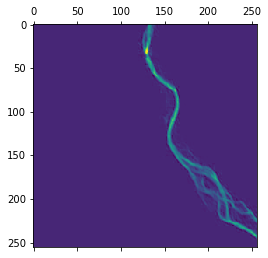

[64,     9] train_err: 1.407 	  test_err: 1.000 	 avg_loss: 0.007
[65,    21] train_err: 1.000 	  test_err: 1.086 	 avg_loss: 0.007
[66,    12] train_err: 0.999 	  test_err: 0.998 	 avg_loss: 0.007


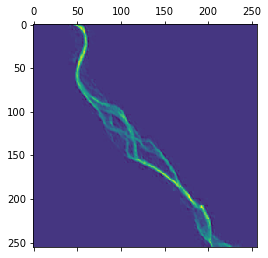

[67,    11] train_err: 1.805 	  test_err: 1.000 	 avg_loss: 0.007
[68,    25] train_err: 1.000 	  test_err: 1.331 	 avg_loss: 0.007
[69,    11] train_err: 1.829 	  test_err: 1.000 	 avg_loss: 0.007


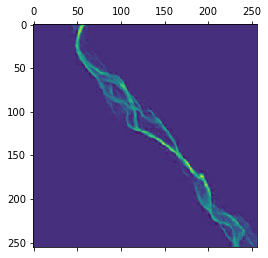

[70,    15] train_err: 0.999 	  test_err: 1.000 	 avg_loss: 0.007
[71,    13] train_err: 1.291 	  test_err: 1.000 	 avg_loss: 0.007
[72,    14] train_err: 1.000 	  test_err: 1.488 	 avg_loss: 0.007


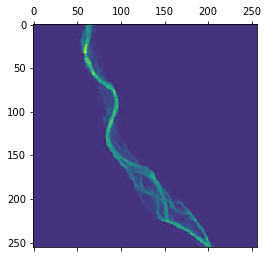

[73,     5] train_err: 1.634 	  test_err: 1.000 	 avg_loss: 0.007
[74,    14] train_err: 1.000 	  test_err: 1.535 	 avg_loss: 0.007
[75,    16] train_err: 1.001 	  test_err: 1.000 	 avg_loss: 0.007


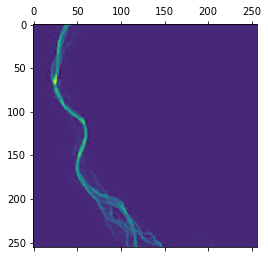

[76,    21] train_err: 1.000 	  test_err: 1.086 	 avg_loss: 0.007
[77,    20] train_err: 0.999 	  test_err: 1.002 	 avg_loss: 0.007
[78,    18] train_err: 1.130 	  test_err: 0.999 	 avg_loss: 0.006


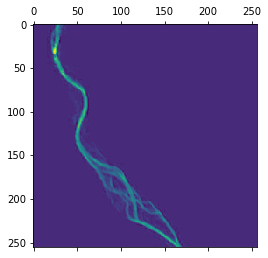

[79,     8] train_err: 1.234 	  test_err: 1.007 	 avg_loss: 0.006
[80,    14] train_err: 0.999 	  test_err: 1.471 	 avg_loss: 0.006
[81,     1] train_err: 0.905 	  test_err: 1.006 	 avg_loss: 0.006


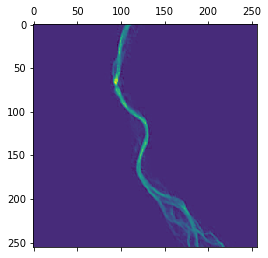

[82,    22] train_err: 1.851 	  test_err: 0.999 	 avg_loss: 0.006
[83,     5] train_err: 1.606 	  test_err: 0.999 	 avg_loss: 0.006
[84,    21] train_err: 0.999 	  test_err: 1.089 	 avg_loss: 0.006


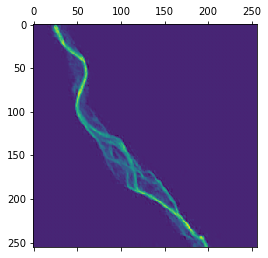

[85,    24] train_err: 0.471 	  test_err: 0.417 	 avg_loss: 0.006
[86,    19] train_err: 1.016 	  test_err: 0.999 	 avg_loss: 0.006
[87,    24] train_err: 0.474 	  test_err: 0.396 	 avg_loss: 0.006


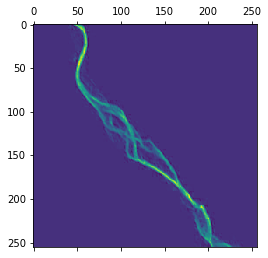

[88,     2] train_err: 0.999 	  test_err: 1.144 	 avg_loss: 0.006
[89,    16] train_err: 0.999 	  test_err: 0.999 	 avg_loss: 0.006
[90,     5] train_err: 1.622 	  test_err: 0.999 	 avg_loss: 0.006


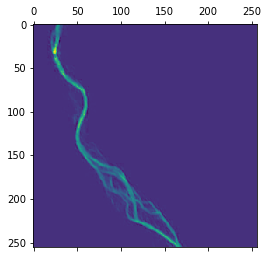

[91,    16] train_err: 1.025 	  test_err: 1.047 	 avg_loss: 0.006
[92,    25] train_err: 0.999 	  test_err: 1.407 	 avg_loss: 0.006
[93,    21] train_err: 1.000 	  test_err: 1.114 	 avg_loss: 0.006


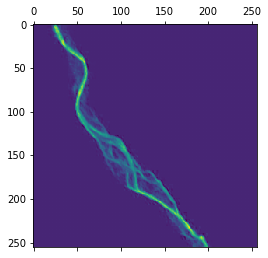

[94,    18] train_err: 1.088 	  test_err: 0.999 	 avg_loss: 0.006
[95,    13] train_err: 1.126 	  test_err: 1.000 	 avg_loss: 0.006
[96,     8] train_err: 1.217 	  test_err: 1.004 	 avg_loss: 0.006


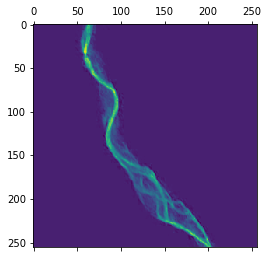

[97,     7] train_err: 1.050 	  test_err: 0.999 	 avg_loss: 0.006
[98,     4] train_err: 0.999 	  test_err: 1.358 	 avg_loss: 0.006
[99,     5] train_err: 1.601 	  test_err: 1.000 	 avg_loss: 0.006


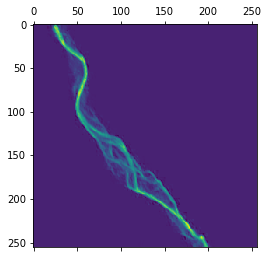

Finished Training


In [22]:
epochs = 100

for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, batch in enumerate(X_train):

        optimizer.zero_grad()

        outputs = net(batch)
        
        loss = criterion(outputs, y_train[i])
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        losses.append(loss.item())

        # print("batch {} - loss {}".format(i, loss.item()))

        if i == len(X_train)-1:
            # randomly pick a test batch and compute it
            i = np.random.randint(len(y_test), size=1)
            
            train_out = net(X_test[i][0])
            test_out = net(X_train[i][0])
            
            train_err = relative_error(train_out, y_train[i]).item()
            test_err = relative_error(test_out, y_test[i]).item()
        
            test_errors.append(test_err)
            errors.append(train_err)
            
            print('[%d, %5d] train_err: %.3f \t  test_err: %.3f \t avg_loss: %.3f' %
                  (epoch, i, train_err, test_err, np.mean(losses)))

    if epoch % 3 == 0:
        i = np.random.randint(len(X_test))
        outputs = net(X_test[i])
        for frame in outputs[0][0]:
            plt.matshow(frame.cpu().detach().numpy())
            plt.show()

        #if epoch % 10 == 0:
        #    print('[%d, %5d] loss: %.3f' %
        #          (epoch + 1, i + 1, running_loss / 2000))
        #    running_loss = 0.0

print('Finished Training')

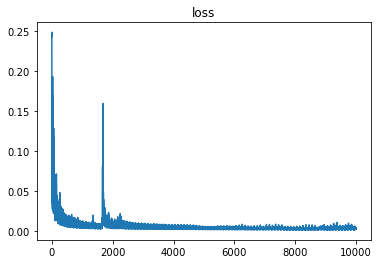

In [23]:
plt.title("loss")
plt.plot(range(len(losses)), losses)
pass

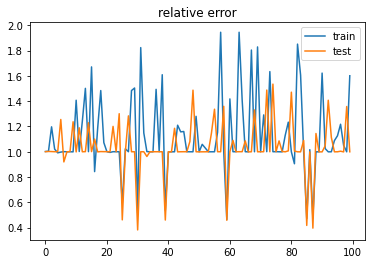

In [24]:
plt.title("relative error")
plt.plot(range(len(errors)), errors, label="train")
plt.plot(range(len(test_errors)), test_errors, label="test")
plt.legend()
pass


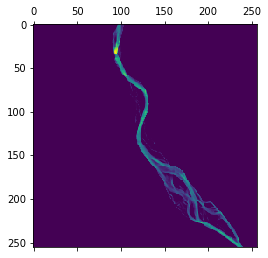

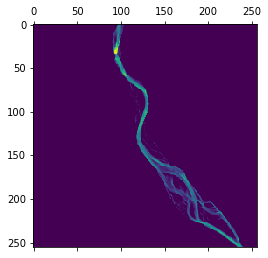

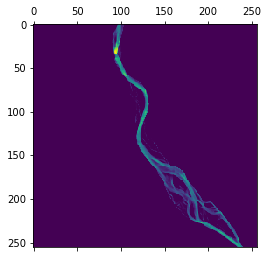

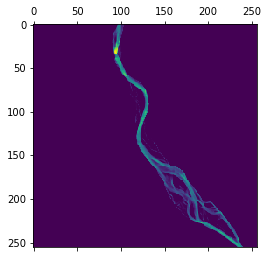

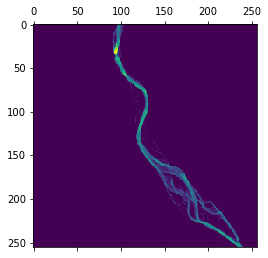

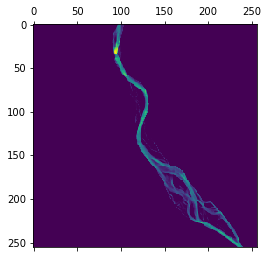

In [39]:
i = np.random.randint(len(X_test))
outputs = net(X_test[i])

for frame in X_test[i][0][0]:
    plt.matshow(frame.cpu().detach().numpy())

#for frame in y_test[i][0][0]:
#    plt.matshow(frame.cpu().detach().numpy())

torch.Size([4, 1, 1, 256, 256])


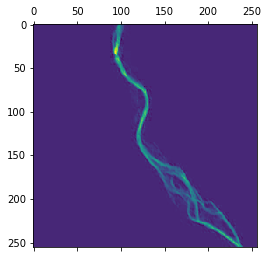

In [40]:
print(outputs.shape)
for frame in outputs[0][0]:
    plt.matshow(frame.cpu().detach().numpy())


In [41]:
print("{:<20s}{:<20s}{:<20s}{:<20s}{:<20s}".format("", "min", "max", "mean", "std"))
print("{:<20s}{:<20f}{:<20f}{:<20f}{:<20f}".format("prediction", th.min(outputs), th.max(outputs), th.mean(outputs), th.std(outputs)))
print("{:<20s}{:<20f}{:<20f}{:<20f}{:<20f}".format("true", th.min(y_test[0]), th.max(y_test[0]), th.mean(y_test[0]), th.std(y_test[0])))

                    min                 max                 mean                std                 
prediction          -0.298845           3.166505            0.043648            0.200144            
true                0.000000            3.672260            0.084363            0.329787            
